<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Often necessary b/c pandas & statsmodels datetime issue
import warnings
warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [5]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


**Creating a datetime index**

Convert the Date column to datetime, and set it as the index for the dataframe.

In [7]:
walmart['Date'] = pd.to_datetime(walmart['Date'])

In [8]:
walmart.set_index('Date', inplace=True) # Set Date as index

In [9]:
walmart # Check work

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False
...,...,...,...,...
2012-09-28,45,98,508.37,False
2012-10-05,45,98,628.10,False
2012-10-12,45,98,1061.02,False


**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **[groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [11]:
# Filter for Store 1
store1 = walmart[walmart['Store'] == 1]

In [12]:
# Group by the 'Date' and aggregate the 'Weekly_Sales'
wkly_sales_store1 = store1.groupby('Date')[['Weekly_Sales']].sum()

In [13]:
wkly_sales_store1.head() # Check work

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

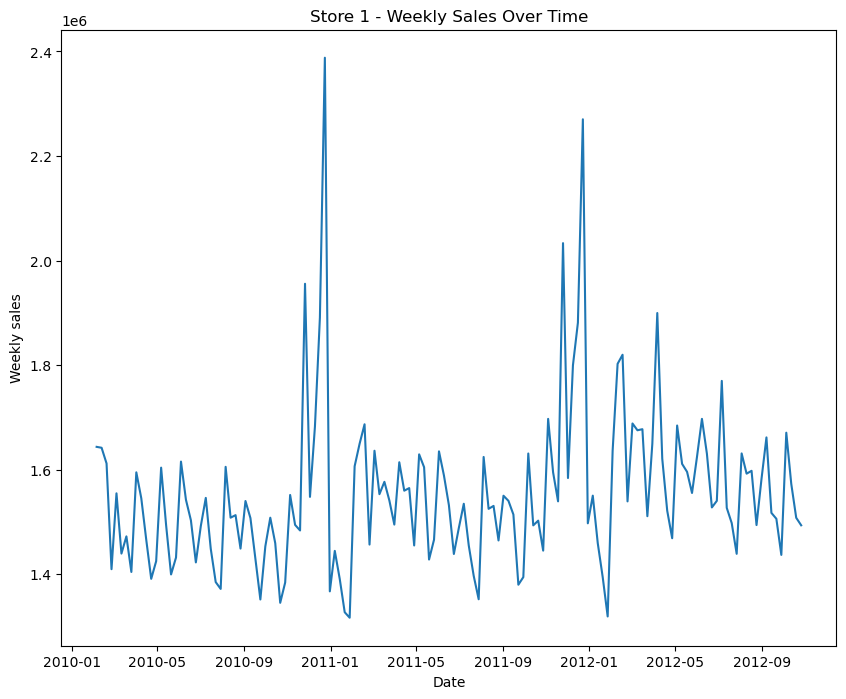

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(wkly_sales_store1)

plt.title('Store 1 - Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly sales')
plt.show()

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

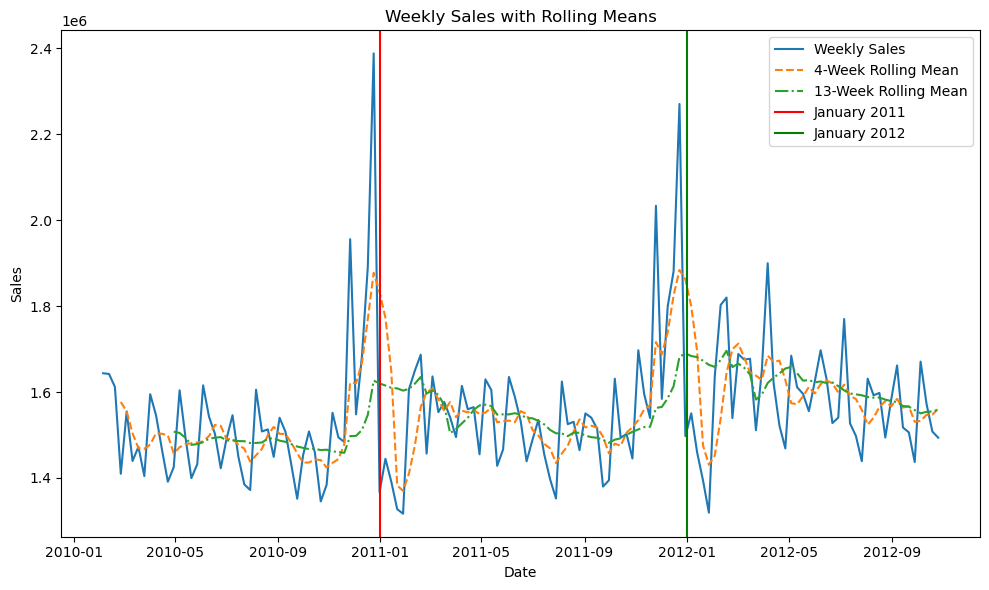

In [17]:
# Plot weekly sales and rolling means
plt.figure(figsize=(10, 6))
plt.plot(wkly_sales_store1.index, wkly_sales_store1['Weekly_Sales'], label='Weekly Sales')
plt.plot(wkly_sales_store1.index, wkly_sales_store1['Weekly_Sales'].rolling(window=4).mean(), label='4-Week Rolling Mean', linestyle='--')
plt.plot(wkly_sales_store1.index, wkly_sales_store1['Weekly_Sales'].rolling(window=13).mean(), label='13-Week Rolling Mean',linestyle='-.')

# Add vertical lines for January 2011 and January 2012
plt.axvline(pd.Timestamp('2011-01-01'), color='red', label='January 2011')
plt.axvline(pd.Timestamp('2012-01-01'), color='green', label='January 2012')

plt.title('Weekly Sales with Rolling Means')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()


**Describe any trends that you notice**

In [19]:
# A: 
# The weekly sales data shows significant volatility, with large spikes and dips.
# The 4-week and 13-week rolling means provide a clearer picture of the underlying sales trends.
# Compared to January 2011 and January 2012, the overall sales levels have increased over time.
# The rolling means help smooth out the week-to-week changes to better identify the underlying sales performance.

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

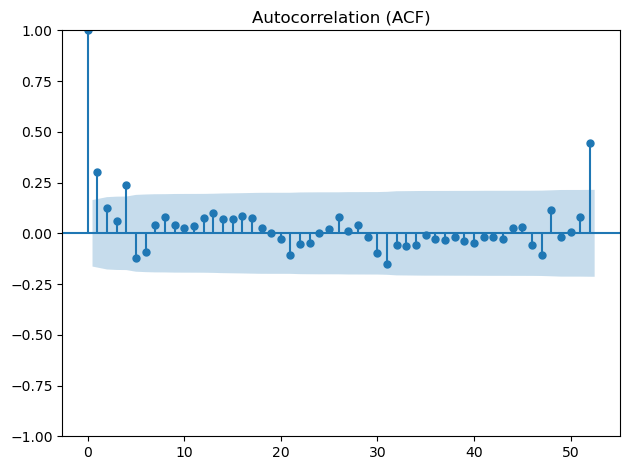

In [21]:
# ACF
plot_acf(wkly_sales_store1['Weekly_Sales'], lags=52, title='Autocorrelation (ACF)')
plt.tight_layout()
plt.show()

In [22]:
# ACF plot:
# High autocorrelation at lag 0
# Periodic spikes indicating potential seasonality
# Values remain within confidence intervals, suggesting stationarity

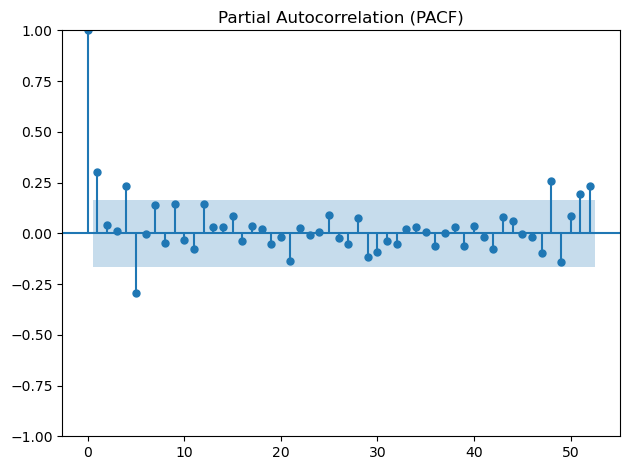

In [23]:
plot_pacf(wkly_sales_store1['Weekly_Sales'], lags=52, ax=plt.gca(), title='Partial Autocorrelation (PACF)')

plt.tight_layout()
plt.show()

In [24]:
# PACF plot: 
# High partial autocorrelation at lag 0
# Fewer periodic spikes compared to ACF
# Values remain within confidence intervals

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [26]:
# Split the data
train = wkly_sales_store1.iloc[:int(len(wkly_sales_store1) * 0.9)] # first 90% of observations as training data      
test = wkly_sales_store1.iloc[int(len(wkly_sales_store1) * 0.9):]  # remaining 10% observants as testing data

In [27]:
train.shape, test.shape

((128, 1), (15, 1))

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [29]:
# Perform the ADF test
adf_statistic, p_value, _, _, crit_values, _ = adfuller(wkly_sales_store1['Weekly_Sales'])

# Display the result
print(f'ADF Statistic: {adf_statistic}, p-value: {p_value}')
print(f'Critical Values: {crit_values}')

# Interpretation
print("Stationary" if p_value < 0.05 else "Non-stationary")

ADF Statistic: -5.102186145192292, p-value: 1.3877788330759122e-05
Critical Values: {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}
Stationary


---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [31]:
# Fit the AR(1) model (ARIMA with order (1, 0, 0)) on the training data
train = train.asfreq('W-FRI')  

model = ARIMA(train['Weekly_Sales'], order=(1, 0, 0)).fit()
model.summary() # Display the model summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1710.923
Date:                Fri, 13 Dec 2024   AIC                           3427.846
Time:                        22:07:37   BIC                           3436.402
Sample:                    02-05-2010   HQIC                          3431.323
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.556e+06   2.31e+04     67.488      0.000    1.51e+06     1.6e+06
ar.L1          0.3081      0.050      6.118      0.000       0.209       0.407
sigma2      2.397e+10      0.172   1.39e+11      0.000     2.4e+10     2.4e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               204.46
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.91e+26. Standard errors may be unstable.
"""

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of **start** and **end** dates.

Generate and store predictions for the training and testing data.

In [33]:
# Prediction for training data
train_pred = model.predict(start=train.index[0], end=train.index[-1])
# Prediction for testing data
test_pred = model.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Use the [mean_squared_error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_squared_error.html) function to identify the MSE on the testing data.

In [35]:
mse = mean_squared_error(test,test_pred)
mse

5188882502.605215

**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

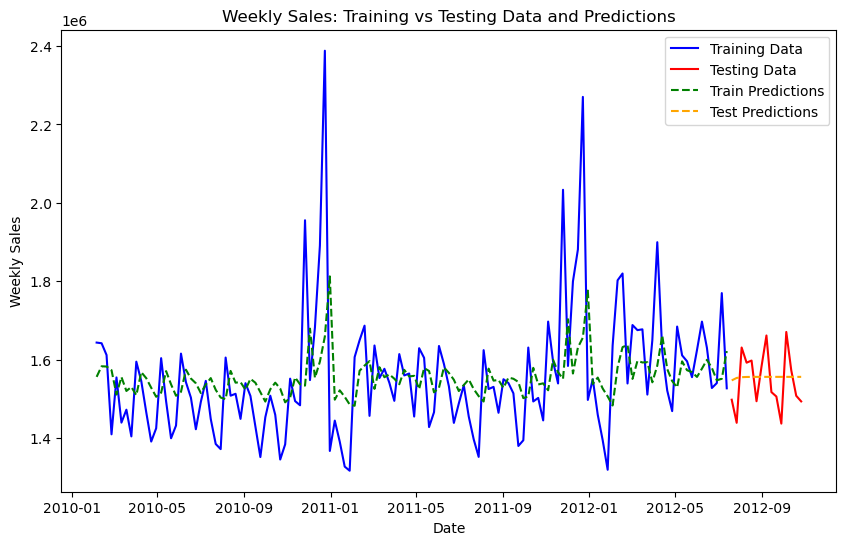

In [37]:
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train.index, train['Weekly_Sales'], label='Training Data', color='blue')

# Plot the testing data
plt.plot(test.index, test['Weekly_Sales'], label='Testing Data', color='red')

# Plot the training predictions
plt.plot(train.index, train_pred, label='Train Predictions', color='green', linestyle='--')

# Plot the testing predictions
plt.plot(test.index, test_pred, label='Test Predictions', color='orange', linestyle='--')


plt.title('Weekly Sales: Training vs Testing Data and Predictions')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [39]:
# The model fits the training data well, but struggles to accurately predict the testing data
# Big gap between the training and testing predictions, indicating potential overfitting

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [41]:
# Fit ARIMA(2, 0, 2)
model2 = ARIMA(train, order=(2, 0, 2)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1701.493
Date:                Fri, 13 Dec 2024   AIC                           3414.985
Time:                        22:07:38   BIC                           3432.097
Sample:                    02-05-2010   HQIC                          3421.938
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.556e+06   2.38e+04     65.255      0.000    1.51e+06     1.6e+06
ar.L1         -1.0500      0.072    -14.590      0.000      -1.191      -0.909
ar.L2         -0.4778      0.066     -7.191      0.000      -0.608      -0.348
ma.L1          1.4604      0.072     20.411      0.000       1.320       1.601
ma.L2          0.9825      0.088     11.217      0.000       0.811       1.154
sigma2      2.279e+10      0.059   3.83e+11      0.000    2.28e+10    2.28e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                74.46
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             1.36
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.37e+27. Standard errors may be unstable.
"""

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [43]:
# Prediction for training data
train_pred2 = model2.predict(start=train.index[0], end=train.index[-1])
# Prediction for testing data
test_pred2 = model2.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Find the MSE of the testing data.

In [45]:
mse2 = mean_squared_error(test,test_pred2)
mse2

4617983455.870269

**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

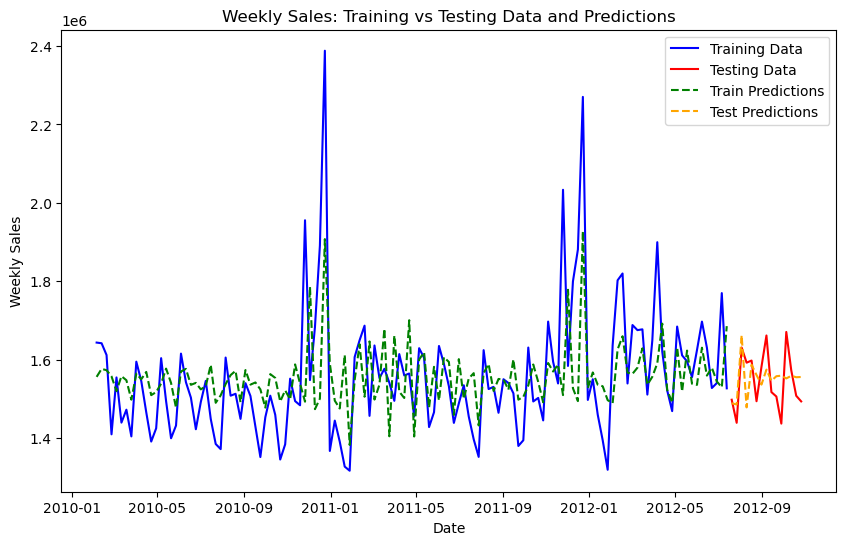

In [47]:
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train.index, train['Weekly_Sales'], label='Training Data', color='blue')

# Plot the testing data
plt.plot(test.index, test['Weekly_Sales'], label='Testing Data', color='red')

# Plot the training predictions
plt.plot(train.index, train_pred2, label='Train Predictions', color='green', linestyle='--')

# Plot the testing predictions
plt.plot(test.index, test_pred2, label='Test Predictions', color='orange', linestyle='--')


plt.title('Weekly Sales: Training vs Testing Data and Predictions')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [49]:
# A: 
# Seems to be overfitting as the earlier models

---
**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [51]:
# Fit ARIMA(2, 1, 2)
model3 = ARIMA(train, order=(2, 1, 2)).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1707.922
Date:                Fri, 13 Dec 2024   AIC                           3425.845
Time:                        22:07:38   BIC                           3440.066
Sample:                    02-05-2010   HQIC                          3431.623
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4178      0.280     -1.494      0.135      -0.966       0.130
ar.L2          0.4121      0.101      4.100      0.000       0.215       0.609
ma.L1         -0.1075      0.278     -0.387      0.699      -0.651       0.436
ma.L2         -0.7808      0.229     -3.408      0.001      -1.230      -0.332
sigma2      2.948e+10   1.54e-11   1.91e+21      0.000    2.95e+10    2.95e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                69.87
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             0.71
Prob(H) (two-sided):                  0.20   Kurtosis:                         6.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.15e+37. Standard errors may be unstable.
"""

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [53]:
# Prediction for training data
train_pred3 = model3.predict(start=train.index[0], end=train.index[-1])
# Prediction for testing data
test_pred3 = model3.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [55]:
mse3 = mean_squared_error(test,test_pred3)
mse3

8383610278.299231

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

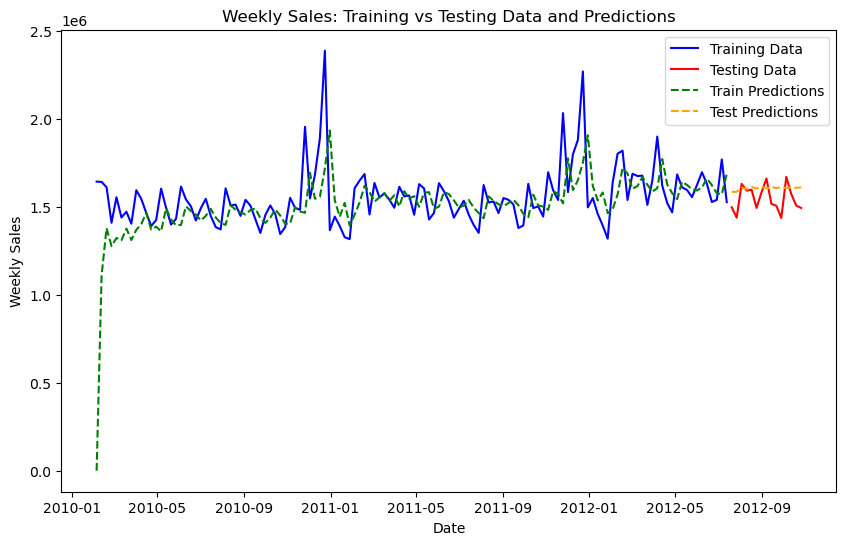

In [57]:
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train.index, train['Weekly_Sales'], label='Training Data', color='blue')

# Plot the testing data
plt.plot(test.index, test['Weekly_Sales'], label='Testing Data', color='red')

# Plot the training predictions
plt.plot(train.index, train_pred3, label='Train Predictions', color='green', linestyle='--')

# Plot the testing predictions
plt.plot(test.index, test_pred3, label='Test Predictions', color='orange', linestyle='--')


plt.title('Weekly Sales: Training vs Testing Data and Predictions')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [59]:
# A:
# Seems to be overfitting as the earlier models

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [61]:
# Fit ARIMA(52, 0, 1)
model4 = ARIMA(train, order=(52, 0, 1)).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                ARIMA(52, 0, 1)   Log Likelihood               -1642.421
Date:                Fri, 13 Dec 2024   AIC                           3394.841
Time:                        22:08:22   BIC                           3551.703
Sample:                    02-05-2010   HQIC                          3458.575
                         - 07-13-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.556e+06    2.7e-07   5.76e+12      0.000    1.56e+06    1.56e+06
ar.L1          0.0623      0.148      0.422      0.673      -0.227       0.352
ar.L2          0.1182      0.119      0.997      0.319      -0.114       0.351
ar.L3         -0.1133      0.086     -1.312      0.190      -0.283       0.056
ar.L4          0.0961      0.101      0.948      0.343      -0.103       0.295
ar.L5         -0.0462      0.106     -0.437      0.662      -0.253       0.161
ar.L6         -0.0785      0.098     -0.798      0.425      -0.271       0.114
ar.L7          0.1435      0.081      1.778      0.075      -0.015       0.302
ar.L8         -0.0678      0.074     -0.922      0.357      -0.212       0.076
ar.L9          0.0444      0.097      0.457      0.648      -0.146       0.235
ar.L10         0.0327      0.081      0.401      0.689      -0.127       0.192
ar.L11        -0.0736      0.075     -0.977      0.329      -0.221       0.074
ar.L12         0.1458      0.086      1.696      0.090      -0.023       0.314
ar.L13         0.0004      0.088      0.005      0.996      -0.171       0.172
ar.L14         0.0023      0.087      0.026      0.979      -0.169       0.174
ar.L15         0.1028      0.070      1.460      0.144      -0.035       0.241
ar.L16        -0.0452      0.073     -0.620      0.536      -0.188       0.098
ar.L17         0.0599      0.079      0.754      0.451      -0.096       0.215
ar.L18         0.0228      0.083      0.275      0.784      -0.140       0.186
ar.L19        -0.0196      0.097     -0.202      0.840      -0.210       0.171
ar.L20         0.0515      0.082      0.625      0.532      -0.110       0.213
ar.L21        -0.0261      0.095     -0.274      0.784      -0.213       0.161
ar.L22         0.0323      0.116      0.278      0.781      -0.196       0.260
ar.L23         0.0068      0.113      0.060      0.952      -0.214       0.227
ar.L24        -0.0585      0.086     -0.683      0.495      -0.226       0.109
ar.L25         0.0555      0.103      0.537      0.591      -0.147       0.258
ar.L26        -0.0326      0.097     -0.338      0.736      -0.222       0.157
ar.L27         0.0035      0.109      0.032      0.975      -0.210       0.217
ar.L28         0.0538      0.091      0.592      0.554      -0.124       0.232
ar.L29        -0.0347      0.079     -0.438      0.661      -0.190       0.121
ar.L30         0.0165      0.128      0.129      0.897      -0.234       0.267
ar.L31        -0.0868      0.110     -0.787      0.431      -0.303       0.129
ar.L32         0.0015      0.103      0.015      0.988      -0.200       0.203
ar.L33         0.0322      0.108      0.298      0.766      -0.180       0.244
ar.L34        -0.0885      0.128     -0.692      0.489      -0.339       0.162
ar.L35         0.0536      0.126      0.426      0.670      -0.193       0.301
ar.L36        -0.0664      0.087     -0.764      0.445      -0.237       0.104
ar.L37        -0.0813      0.082     -0.987      0.324      -0.243       0.080
ar

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [63]:
# Prediction for training data
train_pred4 = model4.predict(start=train.index[0], end=train.index[-1])
# Prediction for testing data
test_pred4 = model4.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [65]:
mse4 = mean_squared_error(test,test_pred4)
mse4

7894126414.596177

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

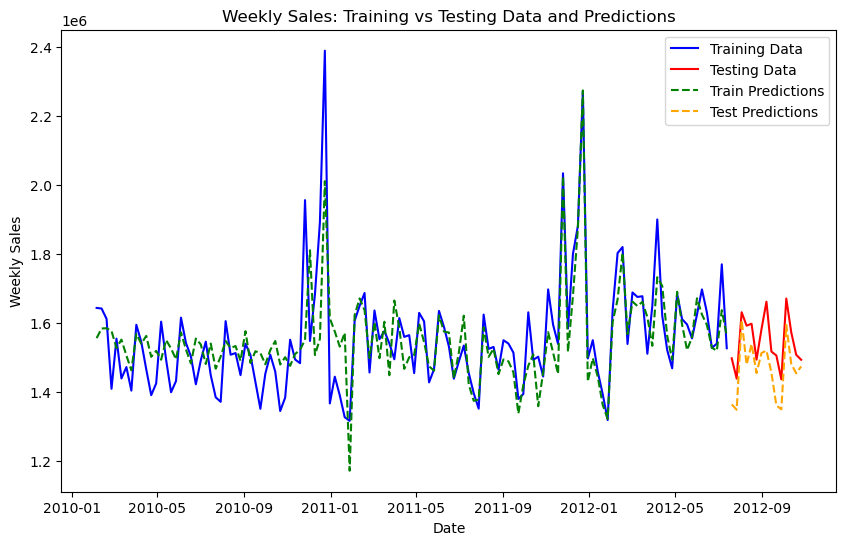

In [67]:
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(train.index, train['Weekly_Sales'], label='Training Data', color='blue')

# Plot the testing data
plt.plot(test.index, test['Weekly_Sales'], label='Testing Data', color='red')

# Plot the training predictions
plt.plot(train.index, train_pred4, label='Train Predictions', color='green', linestyle='--')

# Plot the testing predictions
plt.plot(test.index, test_pred4, label='Test Predictions', color='orange', linestyle='--')


plt.title('Weekly Sales: Training vs Testing Data and Predictions')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [69]:
# A: 
# The model now better captures the training data trends, with closer alignment to actual sales.
# Testing data still diverge from actual sales, indicating overfitting.

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

In [71]:
# Define the SARIMA model with order (2, 0, 2) and seasonal order (1, 1, 1, 52)
sarimax = SARIMAX(train, order=(2, 0, 2), seasonal_order=(1, 1, 1, 52)).fit()
sarimax.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.65908D+00    |proj g|=  5.49359D+00

At iterate    5    f=  7.57613D+00    |proj g|=  8.01876D-01

At iterate   10    f=  7.56777D+00    |proj g|=  3.01272D-01

At iterate   15    f=  7.47856D+00    |proj g|=  5.74045D-01

At iterate   20    f=  7.47468D+00    |proj g|=  2.62549D-01

At iterate   25    f=  7.46139D+00    |proj g|=  6.75317D-02

At iterate   30    f=  7.45753D+00    |proj g|=  5.16561D-03

At iterate   35    f=  7.45531D+00    |proj g|=  3.72976D-02

At iterate   40    f=  7.45416D+00    |proj g|=  2.01343D-02

At iterate   45    f=  7.45260D+00    |proj g|=  1.62773D-02

At iterate   50    f=  7.45230D+00    |proj g|=  1.58654D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         Weekly_Sales   No. Observations:                  128
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 52)   Log Likelihood                -953.894
Date:                              Fri, 13 Dec 2024   AIC                           1921.788
Time:                                      22:08:59   BIC                           1938.104
Sample:                                  02-05-2010   HQIC                          1928.309
                                       - 07-13-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1865      0.424     -0.440      0.660      -1.018       0.645
ar.L2         -0.5999      0.462     -1.297      0.195      -1.506       0.307
ma.L1          0.2086      0.456      0.458      0.647      -0.685       1.102
ma.L2          0.5073      0.517      0.980      0.327      -0.507       1.521
ar.S.L52       0.9908      0.148      6.693      0.000       0.701       1.281
ma.S.L52      -0.9716      0.251     -3.866      0.000      -1.464      -0.479
sigma2      4.971e+09   1.02e-10   4.87e+19      0.000    4.97e+09    4.97e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 4.51
Prob(Q):                              0.36   Prob(JB):                         0.10
Heteroskedasticity (H):               1.94   Skew:                             0.28
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.52e+35. Standard errors may be unstable.
"""

In [72]:
# Prediction for training data
train_pred_sarima = sarimax.predict(start=train.index[0], end=train.index[-1])

# Prediction for testing data
test_pred_sarima = sarimax.predict(start=test.index[0], end=test.index[-1])

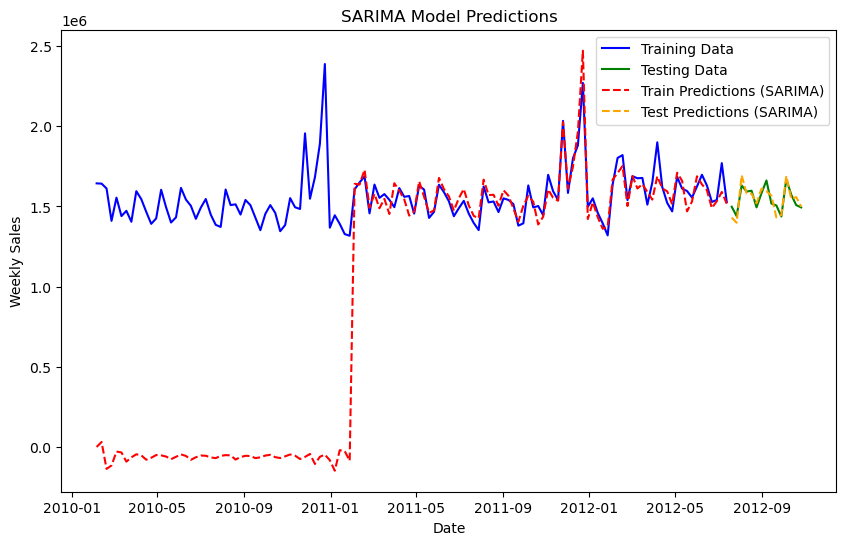

In [73]:
# Plot

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Weekly_Sales'], label='Training Data', color='blue')
plt.plot(test.index, test['Weekly_Sales'], label='Testing Data', color='green')
plt.plot(train.index, train_pred_sarima, label='Train Predictions (SARIMA)', color='red', linestyle='--')
plt.plot(test.index, test_pred_sarima, label='Test Predictions (SARIMA)', color='orange', linestyle='--')
plt.legend(loc='best')
plt.title('SARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

In [74]:
mse5 = mean_squared_error(test,test_pred_sarima)
mse5

1890793068.13738